In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colossus
from scipy.integrate import simps
from scipy.interpolate import interp1d

%matplotlib inline

import astropy.units as u
import astropy.constants as c
from astropy.cosmology import Planck18 as cosmo

## Scales for subhalos

References
* **very useful review:** https://arxiv.org/pdf/1907.11775.pdf, eq 19 for mass function, eq 21 for radial distribution
* **Eq 19 in dark census (projected)** https://arxiv.org/pdf/1506.01724.pdf
* eq 1 of https://arxiv.org/pdf/1006.2882.pdf, original reference https://arxiv.org/pdf/0911.4484.pdf, eq 7 (focus on MW-type halos)
* Book https://ui.adsabs.harvard.edu/abs/2010gfe..book.....M/abstract
* https://arxiv.org/pdf/0802.2265.pdf see eq (3): *Subhalos do not trace the matter distribution of the host: tidal disruption is most effective in the inner halo, which leads to an antibias in the abundance profile of substructure relative to the smooth background, i.e. the radial distribution of subhalos above a given mass is much flatter than that of the dark matter in the host halo. This antibias is less pronounced if subhalos are selected by today’s peak circular velocity instead.*

Ratio between virial and Einstein radius
$$ \frac{R_{\rm vir}}{R_E} = \frac{1.86\cdot 10^4}{(1+z_L)}\left(\frac{1{\rm Gpc}}{d_{\rm eff}}\right)^{1/2} \left(\frac{10^{12}M_\odot}{M_{\rm vir}}\right)^{1/3} $$


The rate associated to encountering a massive halo is given by the strong lensing cross section multiplied by $y_{\rm sub}^2 \equiv (b/R_{\rm E})^2$ or
\begin{equation}
y_{\rm sub} = \frac{1.9\cdot 10^4}{(1+z_L)}\left(\frac{1{\rm Gpc}} {d_{\rm eff}}\right)^{1/2} \left(\frac{10^{12}M_\odot}{M_{\rm vir}}\right)^{1/3}\left(\frac{b}{R_{\rm vir}}\right)\,,
\end{equation}
in terms of an impact parameter $b$.

In [2]:
# zS = 3
# zL = zS/2

zL = 0 #change later

deff = u.Gpc
dL = deff
Mh = 1e12*u.Msun

MLz = 2.3e6*u.Msun*(1+zL)**2*(deff/u.Gpc)*(Mh/1e9/u.Msun)**(4/3)

RE = np.sqrt(c.G/c.c**2*MLz*deff).decompose()
RE.to(u.pc)

<Quantity 1049.11660151 pc>

In [3]:
thE = (RE/dL*u.rad).decompose()
thE.to(u.arcsec)

<Quantity 0.21639583 arcsec>

In [4]:
R200 = (300)**(-1/3)*((c.G*Mh/(70*u.km/u.Mpc/u.s)**2)**(1/3)).decompose()
R200.to(u.kpc)

<Quantity 143.02586556 kpc>

In [5]:
R200/RE

<Quantity 136.32980867>

In [6]:
(R200/RE)**2#*0.07

<Quantity 18585.81673169>

Angular cross section of subhalos within a halo (see notes)

$$ \sigma_s =  \int dm \int d^2x \color{red}{ \xi_0^2} \frac{\Sigma(x)}{m}\frac{df(m,x,z_L)}{dm}\sigma_{\rm WO}(m, x,\vec z) $$

**NOTE: factor of $\xi_0^2$ (of main halo) to convert units in $\Sigma$**

One can define an effective impact parameter for subhalos as $y_{sub}^2(m,M_{\rm vir},\vec z) = \sigma_s/\theta_E(M_{\rm vir})^2$. This can be then inserted in the expression used for isolated halos to get the rate of subhalo lensing.

Let us now assume that the critical impact parameter is that of the isolated halos, so $\sigma_{\rm WO} = y_{\rm crit}(m,\vec z)^2\theta_E(m,\vec z)^2$. This amounts to neglectingthe external potential from the main halo and nearby subhalos, which tend to make WO deviations more distinguishable \cite{Dai:2018}.
Then, if the subhalo mass function $f$ depends weakly on $x$ (i.e. the probability of a halo is captured by the density profile $\Sigma$) then

$$ \sigma_s \approx \int dm   \frac{M_{\rm vir}}{m}\frac{df(m)}{dm}y^2_{\rm crit}(m)\theta_E^2(m) $$

(we are now omitting the $z_L, z_S$ dependence)

We can also compute the expected number of subhalos contributing WO signatures for a given $x$:

$$\bar N_{\rm WO, sub} = \int dm \frac{\Sigma(x)}{m}\frac{df(m,x,z_L)}{dm}\color{red}{\mathcal{A}_{\rm WO}}(m, x, \vec z) $$

Where $\mathcal{A}_{\rm WO} \sim y_{\rm crit}^2(m)R_E^2(m)$ is the actual area on which subhalos can be detected.

and then consider the probability of encountering a source forming an image at that value of $x$.

**SIS:** $M_v = 1.8\cdot 10^{11}M_\odot(\sigma_v/70{\rm km/s})^3$, $\Sigma(\xi) = \frac{\sigma_v^2}{2 G \xi}$, $\xi_0 = \sigma_v^2/(G\Sigma_{\rm crit})$

$$\Sigma(x) = \frac{\Sigma_{\rm crit}}{2x}$$

$$\Sigma_{\rm crit} = \frac{1}{4\pi G(1+z_L)d_{\rm eff}}= 1662.9\frac{M_\odot}{{\rm pc}^2}\frac{1}{1+z_L}\left(\frac{{\rm Gpc}}{d_{\rm eff}}\right)$$

Number of halos for SIS profile (check prefactors!!! so far fixed $d_{eff}$)

$$\bar N_{\rm WO, sub} = \frac{0.915}{x}\int dm \frac{10^9 M_\odot}{m}\frac{df(m,x,z_L)}{dm}\color{red}{\mathcal{A}_{\rm WO}}(m, x, \vec z) $$

Simplest thing is $\frac{df}{dm} = \frac{f_{\rm sub}}{m}e^{-m/M_{\rm vir}}$ (scale invariant with cutoff at the halo mass$

In [7]:
deff = u.Gpc
Sigma_crit = 1/(4*np.pi*c.G/c.c**2*deff).decompose()
Sigma_crit.to(u.Msun/u.pc**2)
#Sigma_crit.to(u.Msun/u.kpc**2)

<Quantity 1662.91654018 solMass / pc2>

In [8]:
def r_Einst(Mh,deff = u.Gpc):

    Mh = Mh*u.Msun

    MLz = 2.3e6*u.Msun*(1+zL)**2*(deff/u.Gpc)*(Mh/1e9/u.Msun)**(4/3)

    RE = np.sqrt(c.G/c.c**2*MLz*deff).decompose()
    
    return RE

# r_Einst = np.vectorize(r_Einst)

In [9]:
rE = r_Einst(1e12)

0.5*(rE**2*Sigma_crit).to(u.Msun)

<Quantity 9.15140923e+08 solMass>

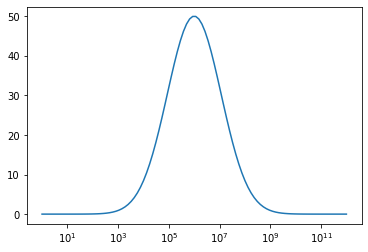

In [10]:
masses = np.geomspace(1,1e12,100)

#model with a lognormal
y0 = 50
M0 = 1e6
s0 = 1.5
ycrit = y0*np.exp(-(np.log10(masses/M0)/(s0))**2)
# ycrit
plt.semilogx(masses,ycrit)

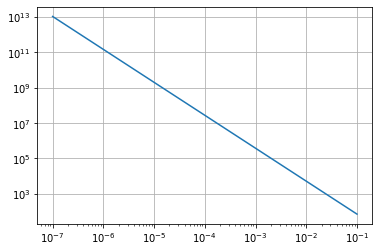

In [11]:
mrel = np.geomspace(1e-7,1e-1,100)
dNdM = mrel**(-1.86)

plt.loglog(mrel,dNdM)
plt.grid()

1.8302818455567995e-07


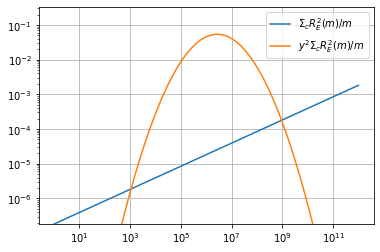

In [12]:
masses = np.geomspace(1,1e12,100)
rE = [(r_Einst(m)/u.pc).decompose() for m in masses]
factor = [(Sigma_crit*r_Einst(m)**2/u.Msun).decompose() for m in masses]


#model with a lognormal
y0 = 50
M0 = 1e6
s0 = 1.5
ycrit = y0*np.exp(-(np.log10(masses/M0)/(s0))**2)


print(factor[0])

# plt.loglog(masses,rE,label='$R_E$ [pc]')
var0=factor/masses
plt.loglog(masses,var0,label='$\Sigma_c R_E^2(m)/m$')
plt.loglog(masses,ycrit**2*var0,label='$y^2\Sigma_c R_E^2(m)/m$')

plt.legend()
plt.grid()
plt.ylim(var0.min(),)
plt.axhline(1,color='gray',ls='--')

# factor = (Sigma_crit*r_Einst(m)**2/u.Msun).decompose()

## Rates in light of PTA data

In [13]:
#retrieve data from https://arxiv.org/pdf/2305.05955.pdf
from os import listdir
from os.path import isfile, join, splitext
pta_path = '/home/miguel/code/notebooks/gw_data/PTA_lim_MBHB_230505955/'
pta_names = [splitext(f)[0] for f in listdir(pta_path) if isfile(join(pta_path, f))]
# print(onlyfiles)

pta_data = {}

for f in pta_names:
    if 'full' in f:
        continue
    filename = pta_path+f+'.csv'
    pta_data[f] = np.genfromtxt(filename,delimiter=',')
    
print(pta_data.keys())

dict_keys(['agnostic_90_upper', 'agnostic_50_upper', 'astro_50_upper', 'astro_90_upper', 'agnostic_50_lower', 'astro_90_lower', 'agnostic_median', 'astro_median', 'astro_50_lower'])


In [23]:
from numpy.random import poisson
from scipy.stats import poisson as poiss
from scipy.special import gamma

from scipy.integrate import simps,cumtrapz
from scipy.interpolate import griddata

np.floor(3.5)

3.0

In [29]:
def latex_exp(x, exp_min = (0,0),ndec=2,forms=('g','g')):
    if x == 0:
        return '%g'%x
    expon = np.log10(x)
    expon = np.floor(expon) if expon>0 else np.ceil(expon)
    if expon>=exp_min[0] and expon<exp_min[1]:
        ndec = max(ndec,exp_min[1] if expon>0 else -exp_min[0])
#         print('*',x)
        n = ndec if np.abs(x)>1 else ndec-1
        form = '%.'+('%i'%n)+forms[0]
#         print(form)
#         form = '%.'+form+'g'
        return form%x
    mant = x/10**expon
    if mant ==1:
#         print('.',x)
        return '10^{%i}'%(expon)
    else:
        form = '%.'+('%i'%(ndec-1))+forms[1]
        return (form+'\cdot 10^{%i}')%(mant,expon)
    
latex_exp(1.1,exp_min=(-2,2))

'1.1'

In [30]:
#output from Stefano

Mbbh=[1e5, 1e6, 1e7]
z_S=[3, 5, 8, 10]
lambda_wo=[[0.026674146917436796,
  0.05070347785752591,
  0.08340254319921814,
  0.10110685326664795],
 [0.19113249871505728,
  0.21243336993160855,
  0.15506866007936593,
  0.12318028115880689],
 [0.0538947158340833,
  0.04569343654895107,
  0.02442326460587767,
  0.01410021483517128]]
lambda_sl=[0.005940430380461109,
  0.01156095373763084,
  0.01818539266276898,
  0.02154655568552058]

lambda_sl = np.array(lambda_sl)
lambda_wo = np.array(lambda_wo).T

# plt.loglog(Mbbh,lambda_wo[1])
lambda_wo[1]

array([0.05070348, 0.21243337, 0.04569344])

In [31]:
np.concatenate((Mbbh,[1e8,1e10]))

array([1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+10])

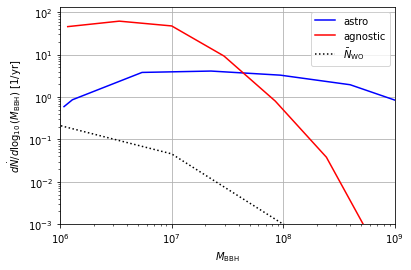

In [32]:
#estimated rates
Mbhs = np.array(np.concatenate((Mbbh,[1e8,1e10])))
barNs = np.array(np.concatenate((lambda_wo[1],[0.001,1e-5]))) #take the z=5
barNwo = interp1d(Mbhs,barNs,fill_value=0)

plt.loglog(pta_data['astro_median'][:,0],pta_data['astro_median'][:,1],'b-',label='astro')
plt.loglog(pta_data['agnostic_median'][:,0],pta_data['agnostic_median'][:,1],'r-',label='agnostic')
# for d1,d2 in [('agnostic_50_upper','agnostic_50_lower')]:
#     plt.fill_between(pta_data[d1][:,0],pta_data[d2][:,1],pta_data[d2][:,1],color='r',alpha=0.2)

plt.loglog(Mbhs,barNs,'k:',label=r'$\bar N_{\rm WO}$')
plt.legend()
plt.ylabel(r'$d\dot N/d\log_{10}(M_{\rm BBH})$ [1/yr]')
plt.xlabel(r'$M_{\rm BBH}$')
plt.ylim(1e-3,)
plt.xlim(1e6,1e9)
plt.grid()

In [33]:
def f_hmf_bounds(Nwo,Ndet,quantil = [0.05,0.5,0.95]):
    '''compute the limits on the halo mass function ratio, given fiducial Nwo, Ndet
       assumes data is given by fiducial (i.e. k_wo = floor(N_wo))
    '''
    
    #define a grid
    n = 1
    rescale = Nwo**n 
    rlim = np.max([100/Ndet**n,1.01])
    flim = np.max([100/Nwo**n,2])
#     f = np.geomspace(0.001*rescale,1000/rescale,1000)
    f = np.geomspace(1/flim,flim,1000)
    r = np.geomspace(1/rlim,rlim,100)
    F, R = np.meshgrid(f,r)

    #likelihood
    kwo = np.floor(Nwo)
    kdet = np.floor(Ndet)
    L = poiss.pmf(kwo,Nwo*R*F)*poiss.pmf(kdet,Ndet*R)

    
#     plt.contourf(F,R,L); plt.xscale('log'); plt.yscale('log')
    
    #marginalize
    Lf = simps(L,R,axis=0)

    cumLf = cumtrapz(Lf,f,initial=0)
    cumLf/=cumLf[-1]
    
#     plt.semilogx(f,cumLf)

    return griddata(cumLf,f,quantil)

# f_hmf_bounds(1000,10000)
f_hmf_bounds(16005.6*5,127395*5)

array([0.99378239, 1.00000938, 1.00626326])

In [34]:
T = 5 #in years

distributions = {}
labels ={}

print(r'Limit  &  5\%  & 95\% \\')
print('\hline')
for i,n in enumerate(datasets): #(['agnostic_50_lower']):
    d = pta_data[n]
    Ntot = simps(d[:,1],np.log10(d[:,0]))
    Nwo = simps(d[:,1]*barNwo(d[:,0]),np.log10(d[:,0]))
    
    Nsl = simps(d[:,1]*barNsl,np.log10(d[:,0]))
    
    labels[n] = names[i]
    
    limits = f_hmf_bounds(T*Nwo,T*Ntot)
    
    val_labs = ['$%.3f$'%v if v <20 else '$%s$'%latex_exp(v) for v in limits]
    #treat special cases
    if Nwo*T<1:
        val_labs[0] = '$-$'
    
    print(names[i],r'& %s & %s \\'%(val_labs[0],val_labs[2]))
#     if Nwo*T <1:
#         print(names[i],r' & $-$ & $%.3f$  \\'%limits[2])
#     else:
#     print(names[i],r' & $%.3f$ & $%.3f$  \\'%tuple([limits[n] for n in [0,2]]))
    if i ==3:
        print('\hline')
print('\hline')

Limit  &  5\%  & 95\% \\
\hline
Agnostic 95\% & $0.995$ & $1.005$ \\
Agnostic 75\% & $0.976$ & $1.025$ \\
Agnostic 50\% & $0.766$ & $1.261$ \\
Agnostic 25\% & $-$ & $3\cdot 10^{3}$ \\
\hline
Astro 95\% & $0.883$ & $1.132$ \\
Astro 75\% & $0.664$ & $1.490$ \\
Astro 50\% & $0.345$ & $2.835$ \\
Astro 25\% & $-$ & $7.139$ \\
Astro 5\% & $-$ & $5\cdot 10^{2}$ \\
\hline


In [36]:
#complete table

T = 5 #in years

distributions = {}
labels ={}

print(r'Limit &  $\dot N_{\rm det}$ &  $\dot N_{\rm WO}$ & $\dot N_{\rm SL}$ &',end=' ')
print(r'  5\%  & 95\% \\')
print('\hline')
for i,n in enumerate(datasets): #(['agnostic_50_lower']):
    d = pta_data[n]
    Ntot = simps(d[:,1],np.log10(d[:,0]))
    Nwo = simps(d[:,1]*barNwo(d[:,0]),np.log10(d[:,0]))
    
    Nsl = simps(d[:,1]*barNsl,np.log10(d[:,0]))
    
    labels[n] = names[i]
    
    limits = f_hmf_bounds(T*Nwo,T*Ntot)
    
    val_labs = ['$%.3f$'%v if np.abs(v-1) <.1 else '$%s$'%latex_exp(v,exp_min=(-1,2),ndec=3) for v in limits]
    #treat special cases
    if Nwo*T<1:
        val_labs[0] = '$-$'
    if Ntot*T <1:
        val_labs[2] = '$-$'
    string = names[i] + r' & $%s$ & $%s$  & $%s$ '%tuple([latex_exp(n,exp_min=(-1,2),forms=('g','g'),ndec=4) for n in [Ntot, Nwo, Nsl]])
    string += r'& %s & %s \\'%(val_labs[0],val_labs[2])
    
    print(string)
                            
    if i ==3:
        print('\hline')
print('\hline')

Limit &  $\dot N_{\rm det}$ &  $\dot N_{\rm WO}$ & $\dot N_{\rm SL}$ &   5\%  & 95\% \\
\hline
Agnostic 95\% & $1.27\cdot 10^{5}$ & $2.61\cdot 10^{4}$  & $1.47\cdot 10^{3}$ & $0.995$ & $1.005$ \\
Agnostic 75\% & $5.21\cdot 10^{3}$ & $1.02\cdot 10^{3}$  & $60.24$ & $0.976$ & $1.025$ \\
Agnostic 50\% & $66.34$ & $8.797$  & $0.767$ & $0.77$ & $1.26$ \\
Agnostic 25\% & $0.0757$ & $0.473\cdot 10^{-2}$  & $0.876\cdot 10^{-3}$ & $-$ & $-$ \\
\hline
Astro 95\% & $3.28\cdot 10^{2}$ & $35.24$  & $3.787$ & $0.88$ & $1.13$ \\
Astro 75\% & $40.63$ & $3.262$  & $0.47$ & $0.66$ & $1.49$ \\
Astro 50\% & $8.55$ & $0.476$  & $0.0988$ & $0.35$ & $2.84$ \\
Astro 25\% & $2.163$ & $0.106$  & $0.025$ & $-$ & $7.14$ \\
Astro 5\% & $0.22$ & $0.679\cdot 10^{-2}$  & $0.254\cdot 10^{-2}$ & $-$ & $4.8\cdot 10^{2}$ \\
\hline


### Further tests

In [19]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base==1:
            return r"10^{{{0}}}".format(int(exponent))
        if base==-1:
            return r"-10^{{{0}}}".format(int(exponent))
        else:
            return r"{0} \cdot 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

latex_float(127395)

'1.3 \\cdot 10^{5}'

In [20]:
#strong lensing rate (assumed)

barNsl = lambda_sl[1] #LISA at z=5, optimistic bc it is at high end

datasets = ['agnostic_90_upper', 'agnostic_50_upper', 'agnostic_median','agnostic_50_lower', 'astro_90_upper', 'astro_50_upper' , 'astro_median', 'astro_50_lower', 'astro_90_lower']
names = ['Agnostic 95\%', 'Agnostic 75\%',  'Agnostic 50\%' , 'Agnostic 25\%', 'Astro 95\%', 'Astro 75\%' , 'Astro 50\%', 'Astro 25\%', 'Astro 5\%']

print('Limit  \t \t  \t    N_tot  \t  N_wo \t \t N_sl')
for i,n in enumerate(datasets):
    d = pta_data[n]
    Ntot = simps(d[:,1],np.log10(d[:,0]))
    Nwo = simps(d[:,1]*barNwo(d[:,0]),np.log10(d[:,0]))
    Nsl = simps(d[:,1]*barNsl,np.log10(d[:,0]))
    print(n,'   \t   %g  \t %g  \t %g \t [yr^-1] '%(Ntot, Nwo, Nsl))

Limit  	 	  	    N_tot  	  N_wo 	 	 N_sl
agnostic_90_upper    	   127395  	 26078.4  	 1472.81 	 [yr^-1] 
agnostic_50_upper    	   5210.88  	 1021.53  	 60.2427 	 [yr^-1] 
agnostic_median    	   66.3417  	 8.79671  	 0.766973 	 [yr^-1] 
agnostic_50_lower    	   0.075736  	 0.00473489  	 0.000875581 	 [yr^-1] 
astro_90_upper    	   327.526  	 35.2409  	 3.78651 	 [yr^-1] 
astro_50_upper    	   40.6317  	 3.2618  	 0.469741 	 [yr^-1] 
astro_median    	   8.5503  	 0.475779  	 0.0988496 	 [yr^-1] 
astro_50_lower    	   2.16296  	 0.105934  	 0.0250058 	 [yr^-1] 
astro_90_lower    	   0.219908  	 0.00678825  	 0.00254235 	 [yr^-1] 


In [21]:
print('%s, %s, %s' % tuple(latex_float(n) for n in [Ntot, Nwo, Nsl]))


0.22, 0.0068, 0.0025


In [22]:
print(r'Limit &  $\dot N_{\rm det}$ &  $\dot N_{\rm WO}$ & $\dot N_{\rm SL}$ \\ \hline')
for i,n in enumerate(datasets):
    d = pta_data[n]
    Ntot = simps(d[:,1],np.log10(d[:,0]))
    Nwo = simps(d[:,1]*barNwo(d[:,0]),np.log10(d[:,0]))
    Nsl = simps(d[:,1]*barNsl,np.log10(d[:,0]))
    print(names[i],r' & $%s$ & $%s$  & $%s$  \\'%tuple([latex_float(n) for n in [Ntot, Nwo, Nsl]]))
    if i ==3:
        print('\hline')
print('\hline')

Limit &  $\dot N_{\rm det}$ &  $\dot N_{\rm WO}$ & $\dot N_{\rm SL}$ \\ \hline
Agnostic 95\%  & $1.3 \cdot 10^{5}$ & $2.6 \cdot 10^{4}$  & $1.5 \cdot 10^{3}$  \\
Agnostic 75\%  & $5.2 \cdot 10^{3}$ & $1 \cdot 10^{3}$  & $60$  \\
Agnostic 50\%  & $66$ & $8.8$  & $0.77$  \\
Agnostic 25\%  & $0.076$ & $0.0047$  & $0.00088$  \\
\hline
Astro 95\%  & $3.3 \cdot 10^{2}$ & $35$  & $3.8$  \\
Astro 75\%  & $41$ & $3.3$  & $0.47$  \\
Astro 50\%  & $8.6$ & $0.48$  & $0.099$  \\
Astro 25\%  & $2.2$ & $0.11$  & $0.025$  \\
Astro 5\%  & $0.22$ & $0.0068$  & $0.0025$  \\
\hline


Note: the rudimentary observable is the ratio $N_{WO}/N_{det} \propto \bar N_{WO}$, but we need to account for hte Poisson nature of the numbers to get intervals. We can use the classical method in Ref https://iopscience.iop.org/article/10.1086/507406/pdf, Eq. 3 (the point of the paper is to do a more principled analysis)

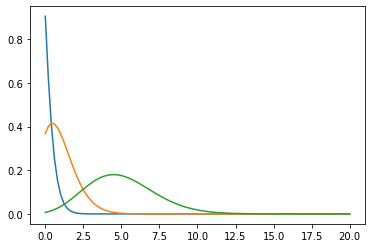

In [321]:
from scipy.special import gamma

def prob_poisson(k,rate):
    
    return rate**k/gamma(k+1)*np.exp(-rate)

k = np.linspace(0,20,100)
for rate in [0.1,1,5]:
    plt.plot(k,prob_poisson(k,rate))

        

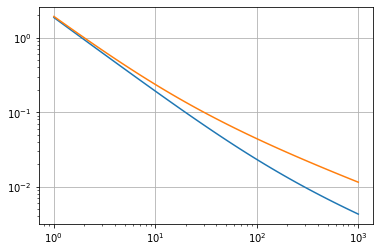

In [330]:
def sigma_gauss_lim(S,H):
    ''' standard deviation of a ratio of Poisson distributions in the Gaussian limit, 
    Eq 3 for S/H of  https://iopscience.iop.org/article/10.1086/507406/pdf, using Gehrels criterion, 
    setting no background (r->infty)'''
    def sg(x):
        return np.sqrt(x+0.75)+1
    
    sS = sg(S)
    sH = sg(H)
    
    return S/H*np.sqrt((sS/S)**2+(sH/H)**2)
    
n = np.geomspace(1,1000)

for rate in [0.01,0.1]:
    plt.loglog(n,sigma_gauss_lim(rate*n,n))
    
plt.grid()

In [338]:
T = 5 #in years
print('Limit  \t \t  \t    N_tot  \t  N_wo \t \t N_sl \t \t sigma_x \n')
for i,n in enumerate(datasets):
    d = pta_data[n]
    Ntot = simps(d[:,1],np.log10(d[:,0]))
    Nwo = simps(d[:,1]*barNwo(d[:,0]),np.log10(d[:,0]))
    Nsl = simps(d[:,1]*barNsl,np.log10(d[:,0]))
    
    sigma_x = sigma_gauss_lim(Nwo*T,Ntot*T)
    
    print(n,'   \t   %g  \t %g  \t %g, \t %.2e \t [yr^-1] '%(Ntot, Nwo, Nsl, sigma_x))

Limit  	 	  	    N_tot  	  N_wo 	 	 N_sl 	 	 sigma_x 

agnostic_90_upper    	   127395  	 16005.6  	 560.54, 	 4.73e-04 	 [yr^-1] 
agnostic_50_upper    	   5210.88  	 629.121  	 22.9279, 	 2.32e-03 	 [yr^-1] 
agnostic_median    	   66.3417  	 5.62406  	 0.291903, 	 1.98e-02 	 [yr^-1] 
agnostic_50_lower    	   0.075736  	 0.00335758  	 0.000333239, 	 4.96e+00 	 [yr^-1] 
astro_90_upper    	   327.526  	 22.6689  	 1.44111, 	 7.35e-03 	 [yr^-1] 
astro_50_upper    	   40.6317  	 2.15508  	 0.178779, 	 2.20e-02 	 [yr^-1] 
astro_median    	   8.5503  	 0.323229  	 0.0376213, 	 5.98e-02 	 [yr^-1] 
astro_50_lower    	   2.16296  	 0.0729789  	 0.009517, 	 1.91e-01 	 [yr^-1] 
astro_90_lower    	   0.219908  	 0.00478777  	 0.000967597, 	 1.71e+00 	 [yr^-1] 


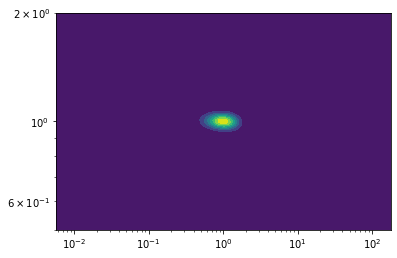

In [21]:
#need to sample likelihood


kdet = 1000
kwo = 10

# if rescale==0:
#     rescale = 1e-5

n = 0.75
rescale = kwo**n 
rlim = np.max([100/kdet**n,2])
f = np.geomspace(0.001*rescale,1000/rescale,1000)
r = np.geomspace(1/rlim,rlim,100)
F, R = np.meshgrid(f,r)


L = poiss.pmf(np.floor(kdet),kdet*R)*poiss.pmf(np.floor(kwo),kwo*R*F)


plt.contourf(F,R,L)
plt.xscale('log')
plt.yscale('log')

[0.61568971 1.70236769]


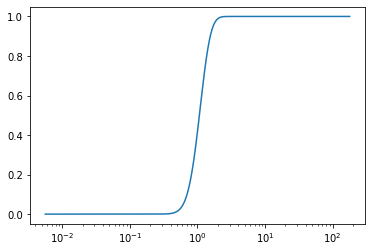

In [22]:
#marginalize

Lf = simps(L,R,axis=0)

# plt.semilogx(f,Lf)
cumLf = cumtrapz(Lf,f,initial=0)
cumLf/=cumLf[-1]
plt.semilogx(f,cumLf)

lims = griddata(cumLf,f,[0.05,0.95])
print(lims)

# print(np.quantile(cumLf,[0.05,0.95]))

### Sampling ratio wo/det
* good approximation to grid for Nwo>1, but more constraining
* can't give bounds when Nwo<1

In [437]:
T = 5 #in years
Nsample = 10000

distributions = {}
labels ={}

print(r'Limit  &  5\%  & 95\% \\')
print('\hline')
for i,n in enumerate(datasets): #(['agnostic_50_lower']):
    d = pta_data[n]
    Ntot = simps(d[:,1],np.log10(d[:,0]))
    Nwo = simps(d[:,1]*barNwo(d[:,0]),np.log10(d[:,0]))
    
    barNfid = Nwo/Ntot
    
    Nsl = simps(d[:,1]*barNsl,np.log10(d[:,0]))
    
    dist_det = poisson(Ntot*T,Nsample)
    dist_wo = poisson(Nwo*T,Nsample)
#     plt.scatter(np.sort(dist_det),np.sort(dist_wo))
#     plt.hist(dist_det)
#     plt.hist(dist_wo)
    
    sample = np.sort(dist_wo)/np.sort(dist_det)
    sample[np.isnan(sample)] = 0
#     plt.hist(sample)    
    
    distributions[n] = sample
    labels[n] = names[i]
    
    limits = np.quantile(sample,[0.05,0.5,0.95])/barNfid
    
    if np.all(limits) == 0:
        print(names[i],r' & $-$ & $-$  \\')
    else:
        print(names[i],r' & $%.3f$ & $%.3f$  \\'%tuple([limits[n] for n in [0,2]]))
    if i ==3:
        print('\hline')
print('\hline')
#     print('%g, %g'%(limits.mean(),np.std(limits)))
#     print('%g'%(sigma_gauss_lim(Nwo,Ntot)*barNfid))

Limit  &  5\%  & 95\% \\
\hline
Agnostic 95\%  & $0.996$ & $1.004$  \\
Agnostic 75\%  & $0.981$ & $1.019$  \\
Agnostic 50\%  & $0.779$ & $1.206$  \\
Agnostic 25\%  & $-$ & $-$  \\
\hline
Astro 95\%  & $0.883$ & $1.111$  \\
Astro 75\%  & $0.618$ & $1.347$  \\
Astro 50\%  & $-$ & $-$  \\
Astro 25\%  & $-$ & $-$  \\
Astro 5\%  & $-$ & $-$  \\
\hline


<ipython-input-437-0e7e7dfd777f>:24: RuntimeWarning: invalid value encountered in divide
  sample = np.sort(dist_wo)/np.sort(dist_det)


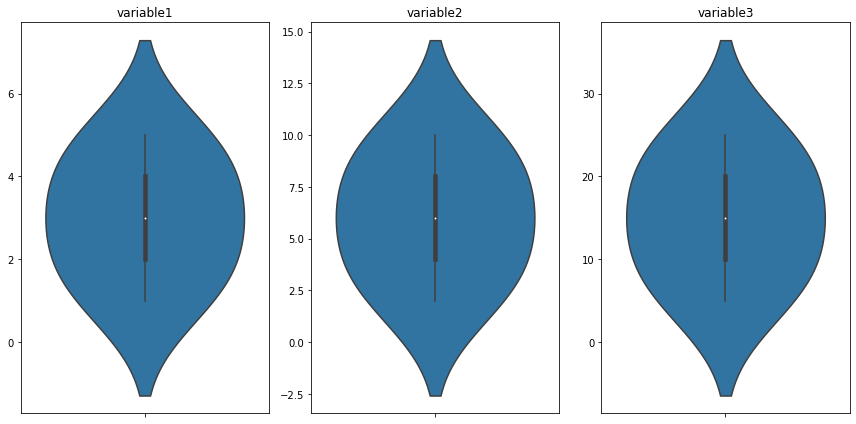

In [412]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example distributions dictionary
distributions = {
    'variable1': [1, 2, 3, 4, 5],
    'variable2': [2, 4, 6, 8, 10],
    'variable3': [5, 10, 15, 20, 25]
}

# Set the figure size and number of columns
plt.figure(figsize=(12, 6))
num_columns = len(distributions)

# Iterate over the distributions and create violin plots
for i, (var_name, data) in enumerate(distributions.items()):
    plt.subplot(1, num_columns, i + 1)
    sns.violinplot(y=data)
    plt.title(var_name)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the violin plots
plt.show()
